#### A quick demonstration of bias-hardened lensing/patchy tau/point source reconstruction in fullsky
#### - this code shows how to compute the estiamtors, and output their power spectra

In [1]:
import numpy as np, basic, curvedsky, plottools as pl, cmb
from matplotlib.pyplot import *

In [2]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 50.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)

#### Load unlensed and lensed Cls

In [3]:
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl
hcl = np.ones(lmax+1)*.5

#### Calculate normalizations

In [4]:
Altt = curvedsky.norm_quad.qtt('amp',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])[0]
Alpp = curvedsky.norm_quad.qtt('lens',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:],lfac='k')[0]
Alss = curvedsky.norm_quad.qtt('src',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])[0]

In [5]:
Rlpt = curvedsky.norm_quad.xtt('lensamp',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:],lfac='k')
Rlps = curvedsky.norm_quad.xtt('lenssrc',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:],lfac='k')
Rlts = curvedsky.norm_quad.xtt('ampsrc',lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])

#### Generate filtered alms

In [6]:
# simple diagonal c-inverse
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [7]:
# generate CMB alms 
# - gaussian alms are generated, and the reconstructed cls are equal to the normalization
Talm, Ealm, Balm = curvedsky.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
tlm = curvedsky.utils.gauss1alm(lmax,1e-5*np.exp(-(L/500.)**2))

In [8]:
# add noise
Talm += curvedsky.utils.gauss1alm(lmax,nl[0,:])
#Ealm += curvedsky.utils.gauss1alm(lmax,nl[1,:])
#Balm += curvedsky.utils.gauss1alm(lmax,nl[2,:])

In [9]:
# diagonal filtering
Talm *= Fl[0,:,:]
#Ealm *= Fl[1,:,:]
#Balm *= Fl[2,:,:]

#### Reconstruction

In [10]:
# compute unnormalized estiamtors
almt = curvedsky.rec_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm)

In [11]:
almp, __ = curvedsky.rec_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,gtype='k')

In [12]:
alms = curvedsky.rec_src.qtt(lmax,rlmin,rlmax,Talm,Talm)

#### Check Normalization

In [13]:
alpp = curvedsky.utils.alm2cl(lmax,almp)
altt = curvedsky.utils.alm2cl(lmax,almt)
alss = curvedsky.utils.alm2cl(lmax,alms)

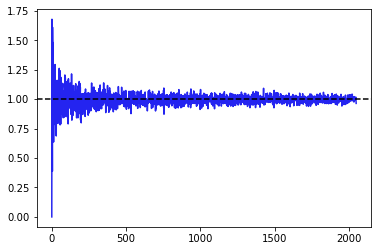

In [14]:
plot((alpp*Alpp))
axhline(1,color='k',ls='--')

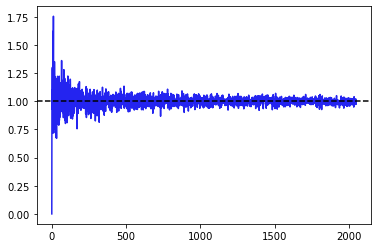

In [15]:
plot((altt*Altt))
axhline(1,color='k',ls='--')

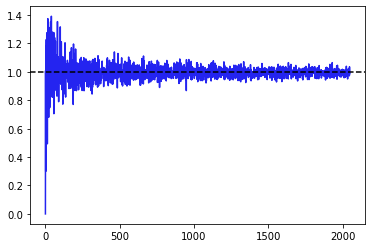

In [16]:
plot((alss*Alss))
axhline(1,color='k',ls='--')

#### Check Response

In [17]:
rlpt = curvedsky.utils.alm2cl(lmax,almp,almt)
rlps = curvedsky.utils.alm2cl(lmax,almp,alms)
rlts = curvedsky.utils.alm2cl(lmax,almt,alms)

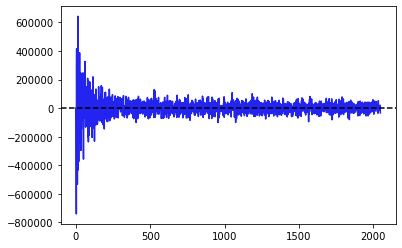

In [18]:
plot((rlpt-Rlpt))
axhline(0,color='k',ls='--')

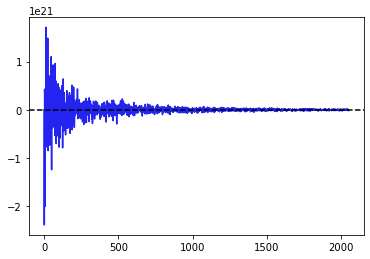

In [19]:
plot((rlps-Rlps))
axhline(0,color='k',ls='--')

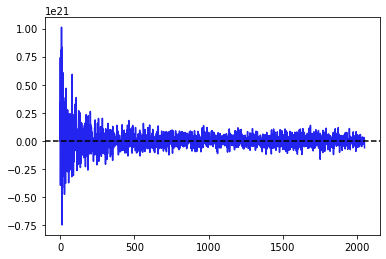

In [20]:
plot((rlts-Rlts))
axhline(0,color='k',ls='--')